In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob 
from scipy.optimize import curve_fit

In [7]:
# get data
df_ctrl = pd.read_csv("D:/work/Cohesin_Paper/Auxin_treatment_Timeseries/Measurements_series1to7.csv")
df_treat = pd.read_csv("D:/work/Cohesin_Paper/Auxin_treatment_Timeseries/Measurements_series8to14.csv")

# return function to add result as new column
def rollmean_dev_gen(df, window_size=5, cutoff=0.1, column='NormMedian', valid_column='Valid'):
    df_tot = []
    for s in pd.unique(df['Series'].values):
        series = df.loc[(df['Series'] == s)]
        for c in pd.unique(series['CellNr'].values):
            cell = series.loc[(series['CellNr'] == c)]
            
            rm = np.convolve(cell[column].values, np.ones(window_size,)/window_size, mode='valid')
            msd = np.mean((cell[column].values[2:len(rm)+2] - rm)**2)
            cell[valid_column] = msd < cutoff
            df_tot.append(cell)

    return pd.concat(df_tot)

# Filter traces by minimum intensity
def rm_low_int(df, intensity=50):
    df_x1 = df[df['X']==1]
    df_int = df_x1[df_x1['Median_SubBackg']<=intensity]
    cellnr = np.array(df_int['CellNr'])
    seriesnr = np.array(df_int['Series'])
    for i in range(len(cellnr)):
        df_new = df.drop(df[(df['Series'] == seriesnr[i]) & (df['CellNr'] == cellnr[i])].index)
        df = df_new
    return df

df_treat = rollmean_dev_gen(rm_low_int(df_treat), cutoff=0.00235) #cutoff = 90 % Quantile
df_ctrl = rollmean_dev_gen(rm_low_int(df_ctrl), cutoff=0.0006) #cutoff = 90 % Quantile

df_treat_filt = df_treat[df_treat.Valid]
df_ctrl_filt = df_ctrl[df_ctrl.Valid]

C:\Users\guirao\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


C:\Users\guirao\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


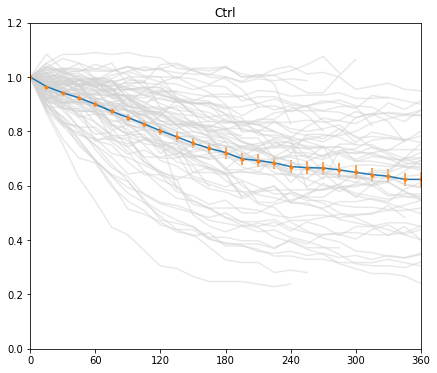

In [8]:
# Plot Control traces (6 hours) with mean trace and standard error
df_ctrl_filt['Minutes'] = (df_ctrl_filt['X']-1)*15

plt.figure(figsize=(7,6))
for _, dfi in df_ctrl_filt.groupby(['CellNr', 'Series']):
    plt.plot(dfi.Minutes, dfi.NormMedian, color='lightgray', alpha=0.5)

means  = []
e = []
for _, dfi in df_ctrl_filt.groupby(['Minutes']):
    means.append(np.mean(dfi.NormMedian))
    e.append(dfi.NormMedian.std()/np.sqrt(len(dfi)))

x = list(range(0, len(means)))
x = [i * 15 for i in x]
plt.plot(x,means)
plt.title('Ctrl')
plt.errorbar(x, means, e, linestyle='None', marker='.')
_ = plt.ylim(0,1.2)
_ = plt.xlim(0,360)
_ = plt.xticks(np.arange(0, 361, step=60))

plt.savefig('Ctrl_timeseries.pdf')  

C:\Users\guirao\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


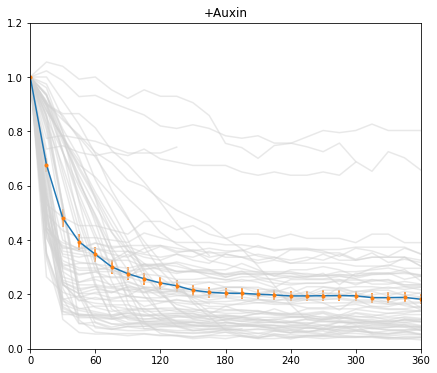

In [9]:
# Plot auxin treated traces (6 hours) with mean trace and standard error
df_treat_filt['Minutes'] = (df_treat_filt['X']-1)*15

plt.figure(figsize=(7,6))
for _, dfi in df_treat_filt.groupby(['CellNr', 'Series']):
    plt.plot(dfi.Minutes, dfi.NormMedian, color='lightgray', alpha=0.5)

means  = []
e = []
for _, dfi in df_treat_filt.groupby(['Minutes']):
    means.append(np.mean(dfi.NormMedian))
    e.append(dfi.NormMedian.std()/np.sqrt(len(dfi)))

x = list(range(0, len(means)))
x = [i * 15 for i in x]
plt.plot(x,means)
plt.title('+Auxin')
plt.errorbar(x, means, e, linestyle='None', marker='.')
_ = plt.ylim(0,1.2)
_ = plt.xlim(0,360)
_ = plt.xticks(np.arange(0, 361, step=60))

plt.savefig('Auxtreat_timeseries.pdf')  